In [1]:
import os, sys, time

sys.path
sys.path.append('./')

import numpy as np
from astropy import wcs
from astropy.io import fits

import matplotlib
matplotlib.use('PDF')
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
# import aplpy

import nbimporter
import function as func

In [2]:
class spectraAna:
    '''
    Class for analyzing image cube. The main purpose of this analysis is to
    stack the un-redshifted/blueshifted spectra.
    
    '''
    
    ### Constructor and destructor
    def __init__(self, fitscubename = ' '):
        self.fitscubename = fitscubename
    
    def __def__(self):
        pass
    
    
    ##function

    ### Methods in this class
    def readfits(self, verbose = False):
        '''
        The task to read the FITS image cube to memory.
        '''
        if verbose == True:
            print('This is the program to read FITS image cube')
            
        if self.fitscubename != ' ':
            if verbose == True:
                print('Reading FITS image cube :' + self.fitscubename)
        
        
        # import FITS image to HDU
        self.Ihdu = fits.open(fitscubename)
        
        # choose the certain information
        self.header = self.Ihdu[0].header
        self.naxis1 = self.Ihdu[0].header['naxis1']
        self.naxis2 = self.Ihdu[0].header['naxis2']
        self.naxis3 = self.Ihdu[0].header['naxis3']
        self.crpix3 = self.Ihdu[0].header['crpix3']
        self.cdelt3 = self.Ihdu[0].header['cdelt3']
        self.crval3 = self.Ihdu[0].header['crval3']
        self.ctype3 = self.Ihdu[0].header['ctype3']
        self.restfreq = self.Ihdu[0].header['RESTFREQ']
        
        
        
        
    def get_velocity(self, verbose = False,if_plot=False):
        '''
        The task to fit centroid frequency pixel-by-pixel.
        
        Input:
        freq_array [1D numpy array] : 
        intensity_array [1D numpy array] : 
        
        Return:
        
        '''
        if verbose == True: 
            print('Fitting centroid frequencies')
            
        
        if_plot = if_plot
            
        centroid_freq = func.fit_1dgaus(freq_array/1e9, intensity_array, plot=if_plot) 
        
        return centroid_freq

                 
     
    def unrbshift_spectra(self, verbose = False, 
                          freq_array = np.array([]), 
                          intensity_array = np.array([]),
                          velocity_array = np.array([]),
                          rest_freq= 2.15219259E+11,
                          centroid_freq = 0, centroid_velo = 0, 
                          plot = False ):
        '''
        
        This function is to un-redshift/blueshift spectra
        
        '''
        if verbose == True:
            print('Unredshifting/unblueshifting spectra')

        rest_freq     = 2.15219259E+11  # rest frequency
        c             = 299792458         # the speed of light
        
        # Doppler effect
        delta_freq = centroid_freq * 1e9 - rest_freq 
        shift_freq = freq_array - delta_freq
        
        shift_velocity = velocity_array - centroid_velo * 1e3
        
        # plot the shifted spectra
        if plot == True:
            func.plot_spectra( 
                                shift_freq /1e9, intensity_array , 
                                xlabel = 'shift freqency[GHz]',
                                datalabel='TBD'
                             )
        
            func.plot_spectra( shift_velocity/1e3, intensity_array, 
                          xlabel = 'shift velocity[km/s]'
                         )
    
        return shift_freq
        
       
    
    def stack_spectra(self, verbose = False):
        '''
        The task to stack the unredshifted/unblueshifted spectra and plot the stacked spectra
        '''
        
        if verbose == True:
            print('Stacking the unredshifted/unblueshifted spectra')

            
        stacked_intensity = np.stack(intensity_list, axis=0)
        sum_intensity     = np.sum(stacked_intensity, axis=0)

        func.plot_spectra(shift_freq/1e9 , sum_intensity[2],
                     outPDF_filename = 'stacked_spectra.pdf')
            

In [3]:
############ Major flow of data analysis ###############################

## Open FITS image cube
fitscubename = '/home/tcc/data/CH30CHO.fits'
myAnalysis = spectraAna(fitscubename = fitscubename)
myAnalysis.readfits(verbose = False)

naxis1     = myAnalysis.naxis1
naxis2     = myAnalysis.naxis2
ctype3     = myAnalysis.ctype3
naxis3     = myAnalysis.naxis3
crpix3     = myAnalysis.crpix3
cdelt3     = myAnalysis.cdelt3
crval3     = myAnalysis.crval3 
restfreq   = myAnalysis.restfreq

## Create the frequency array based on the third axis
if ctype3 == 'VELO-LSR':
    velocity_array = np.zeros( naxis3 )
    velocity_array = crval3 + ( np.arange(naxis3) + 1 - crpix3 ) * cdelt3
    
    c = 299792458
    freq_array = restfreq * (1 - velocity_array / c)

elif cytpe3 == 'FREQ':
    freq_array = np.zeros( naxis3 )
    freq_array = crval3 + ( np.arange(naxis3) + 1 - crpix3 ) * cdelt3



In [18]:
## Read the intensity array 
intensity_list = []
for xpix in range(255,257):
    for ypix in range(361,363):
        intensity_array = myAnalysis.Ihdu[0].data[0][:, ypix, xpix]
        
        if not np.any( np.isnan(intensity_array) ):
            x = xpix
            y = ypix
            intensity_list.append((x,y,intensity_array))
        
        else:
            print(f'Warning: Found NaN values in array at pixel ({xpix},{ypix})')


In [19]:
## To do the gaussian fitting 
filename = 'gaussian_err.log'
os.system('rm -rf '+ filename)
with open(filename,'w') as f:
    
    for x, y, intensity_array in intensity_list:          
        
        try:
            centroid_freq = func.fit_1dgaus(freq_array/1e9, intensity_array, plot = False, kind = 'freq')
            centroid_velo = func.fit_1dgaus(freq_array = velocity_array/1e3, intensity_array = intensity_array, 
                                            plot = False, kind = 'velo',xlabel='Velocity[km/s]')

            if np.isnan(centroid_freq):
                #raise ValueError(f'({x},{y})Centroid frequency is NaN')
                write_string = f'({x},{y})Centroid frequency is NaN\n'
                f.write(write_string)
                intensity_list.remove((x,y,intensity_array))
           
        except Exception as e:
            out_string = f'Pixels (i,j)= ({x},{y})' + ' failed in Gaussian fittings: {str(e)}\n'
            f.write(out_string)
            intensity_list.remove((x,y,intensity_array))
        

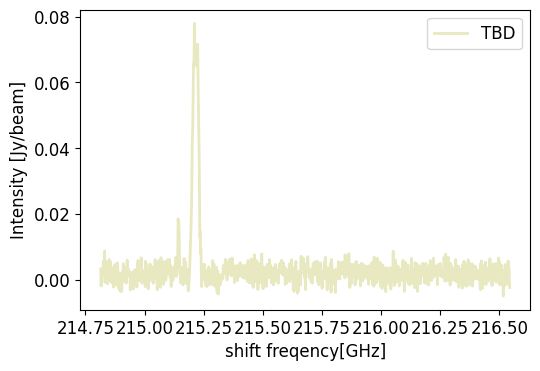

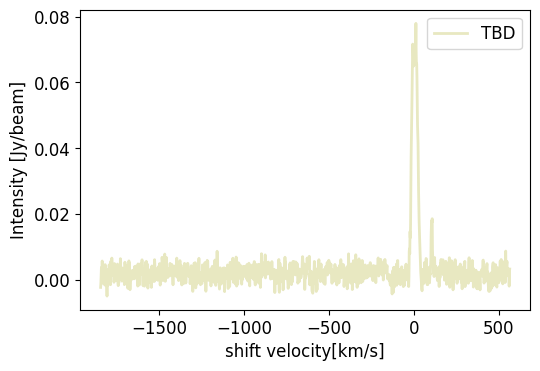

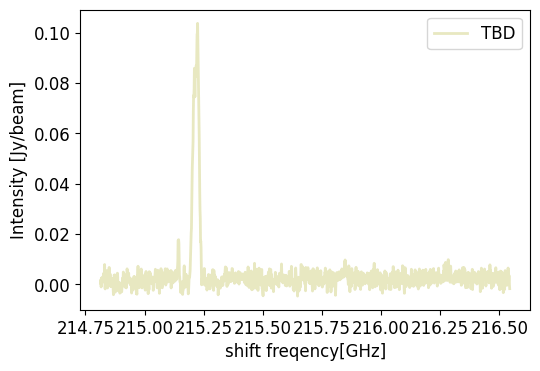

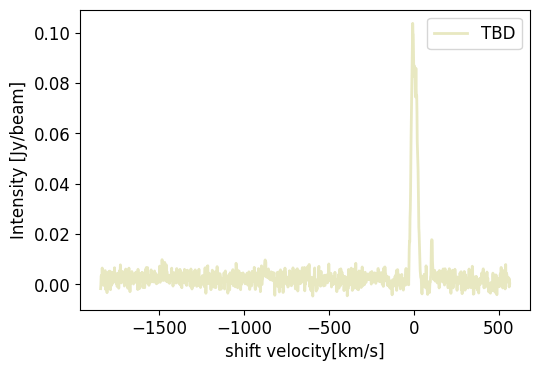

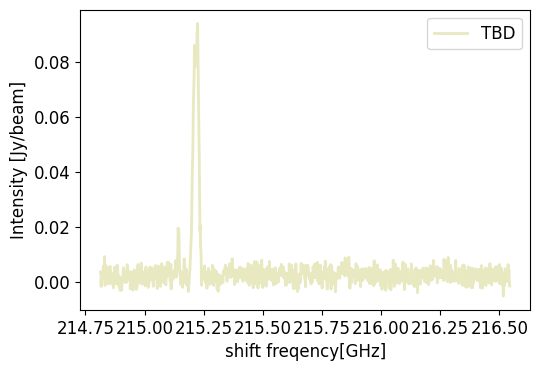

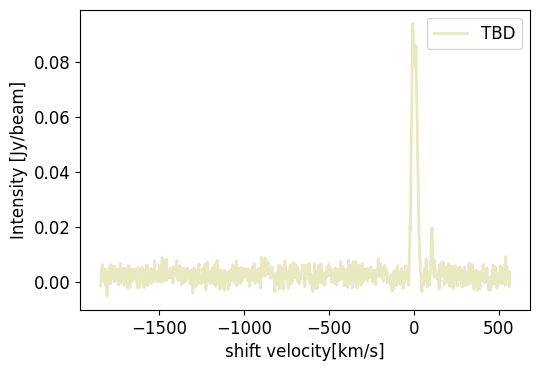

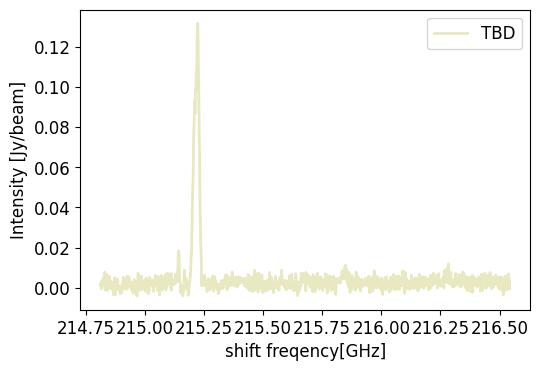

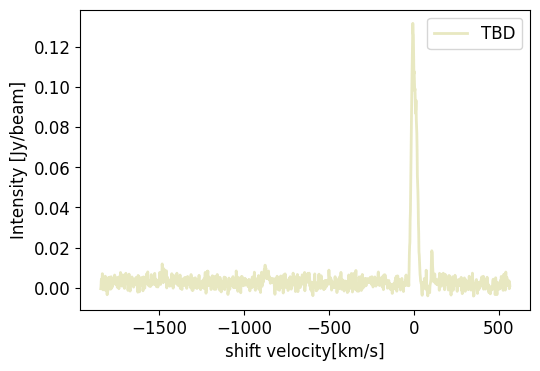

In [20]:
## Unredshift/unblueshift
for x, y, intensity_array in intensity_list:
    try:
        shift_freq = myAnalysis.unrbshift_spectra(
                freq_array=freq_array, intensity_array=intensity_array, velocity_array=velocity_array,
                centroid_freq = centroid_freq,
                centroid_velo = centroid_velo,
                plot = True )

    except Exception as e:
        print(f'Error in pixel ({x},{y}): {str(e)}')

/home/tcc/software/anaconda3/envs/astroimgAna/lib/python3.7/site-packages/numpy/core/shape_base.py:420: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arrays = [asanyarray(arr) for arr in arrays]


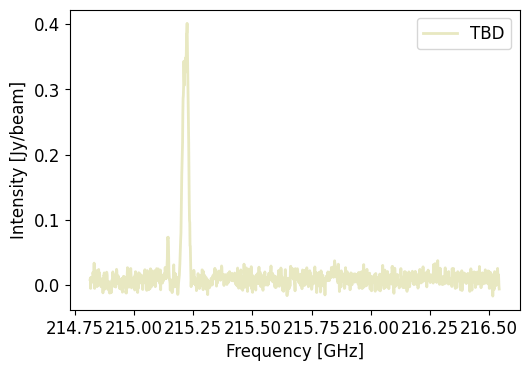

In [21]:
## Stack the spectra and plot it
myAnalysis.stack_spectra(verbose = False)